# Homework 4 - Regularization.

***
**Name**: Nicholas Renninger
***

## Goal

In this assignment you will be experimenting/reproducing results of the regularization techniques in [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf).  
1. Random Dropout
2. Max-norm constraint

Specifically, try to reproduce (just close enough to) some of the MNIST results in section 6.1.1:
1. Dropout w/ logistic activation, 3 layers, 1024 units
2. Dropout w/ RELU activation, 3 layers, 1024 units
3. Dropout + max norm (norm is a hyperparameter, just try a few values), w/ RELU activation, 3 layers, 1024 units

Resources:
- tf [tutorial on over/under-fitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)
- tf [Keras dense layer doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
- tf [Keras constraints doc](https://www.tensorflow.org/api_docs/python/tf/keras/constraints)

**Report your results & write a short summary of any findings.**

## Bonus
Explore L1, L2 normalization (and appropriate model architecture in which these techniques may help), but don't burn too many CPU cycles.

## Due date

Wednesday - 04/08/2020

## Note:
*p* in the paper refers to the present (*1 - dropout*) probability, whereas the tf.keras dropout layer *p* is the dropout probability.

In [0]:
# used to manage a TPU context when in / out of google cloud
from contextlib import suppress

# for GPU training on macOS, use PlaidML backend
import os
from sys import platform
osx_platform_name = 'darwin'
linux_platform_name = 'linux'

# don't want to try to use TPU / tf line magic when not in colab
try:
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
except:
    IN_COLAB = False
    from contextlib import nullcontext

# now we need to alias the plaidML / tf backends depending on the OS to ensure 
# consistent GPU usage
if platform == osx_platform_name:
    %config InlineBackend.figure_format = 'retina'
    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
    import tensorflow.keras as keras
elif platform == linux_platform_name:
    import tensorflow.keras as keras

import matplotlib.pyplot as plt
import numpy as np
from typing import List, Hashable, Tuple

## Initialization

In [0]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
num_train_examples, img_rows, img_cols = x_train.shape
num_test_examples, _, _ = x_test.shape
num_classes = 10

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# data preparation
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, 10)

max_epochs = 100

## Classifier Model Class

In [0]:
class MNISTClassifier:
    """
    An MNIST classifier employing a FCFF NN classifier.
    Used to reproduce the results in the classic regularization paper:
    "Dropout: A Simple Way to Prevent Neural Networks from Overfitting."
    """
    
    def __init__(self, use_dropout: bool,
                 use_maxnorm_regularization: bool,
                 hidden_unit_activation: str,
                 maxnorm_constraint: float=np.Inf,
                 optimizer_name: str='SGD',
                 learning_rate: float=0.01,
                 momentum: float=0.0,
                 hidden_unit_width: int=1024,
                 number_hidden_layers: int=3,
                 num_output_classes: int=num_classes,
                 hidden_unit_dropout_probability: float=0.5,
                 input_dropout_probability: float=0.2) -> 'MNISTClassifier':
        
        """
        Returns an initialized, compiled MNIST classifier
        """
        
        self.class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        self.num_output_classes = num_classes
        
        if use_dropout:
            dropout_prob = hidden_unit_dropout_probability
            input_dropout_prob = input_dropout_probability
        else:
            # using no dropout is the same as having a dropout prob. of 0
            dropout_prob = 0.0
            input_dropout_prob = 0.0

        self.model = keras.Sequential()
        self.model.add(keras.layers.Flatten(input_shape=input_shape))
        self.model.add(keras.layers.Dropout(input_dropout_prob))

        # adding the hidden units to the model
        for i in range(number_hidden_layers):
            self._add_dense_layer(dropout_prob,
                                  use_maxnorm_regularization,
                                  hidden_unit_activation,
                                  hidden_unit_width,
                                  maxnorm_constraint)

        self.model.add(keras.layers.Dense(num_classes, activation='softmax'))

        self.model.compile(loss=keras.losses.categorical_crossentropy,
                           optimizer=self._get_optimizer(optimizer_name,
                                                         learning_rate,
                                                         momentum),
                           metrics=['accuracy'])

    def _get_optimizer(self, optimizer_name: str, learning_rate: float=0.01,
                       momentum: float=0.0) -> keras.optimizers:
        """
        Returns a keras optimizer to train a network
        
        Appropriately sets the parameters of an optimizer based on the desired
        optimizer hyperparameters
        """
        
        if optimizer_name == 'SGD':
            return keras.optimizers.SGD(learning_rate, momentum)
        elif optimizer_name == 'Adam':
            return keras.optimizers.Adam(learning_rate)
        else:
            raise ValueError(f'optimizer name "{optimizer_name}" not recognized')

    def _add_dense_layer(self, dropout_prob: float,
                         use_maxnorm_regularization: bool,
                         hidden_unit_activ: str,
                         hidden_unit_width: int,
                         maxnorm_constraint: float) -> None:
        """
        Adds a Dense FC layer with on the desired layer settings to the model
        """

        if use_maxnorm_regularization:
            constraint = keras.constraints.max_norm(maxnorm_constraint)
            
            self.model.add(keras.layers.Dense(hidden_unit_width,
                                              activation=hidden_unit_activ,
                                              kernel_constraint=constraint))
            self.model.add(keras.layers.Dropout(dropout_prob))
        else:
            self.model.add(keras.layers.Dense(hidden_unit_width,
                                              activation=hidden_unit_activ))
            self.model.add(keras.layers.Dropout(dropout_prob))
    
    def train(self, x_train, y_train,
              batch_size: int=128,
              num_epochs: int=12) -> keras.callbacks.History:
        """
        Trains the model on the given training data, returns training history
        """

        history = self.model.fit(x_train, y_train,
                                 batch_size=batch_size,
                                 epochs=num_epochs,
                                 verbose=1,
                                 validation_split=0.05)

        return history
    
    def validate(self, x_test: np.ndarray, y_test: np.ndarray) -> float:
        """
        Returns the model accuracy on the test inputs and expected outputs
        """

        metrics = self.model.evaluate(x_test, y_test, verbose=1)
        accuracy = metrics[1]

        return accuracy
    
    def infer(self, x) -> Tuple[np.ndarray, int, np.ndarray]:
        """
        Returns the model's distribution over output classes & most likely
        output & a most likely class indicator array for the given input data
        """
        
        output_distribution = self.model.predict(x)
        prediction_idx = np.argmax(output_distribution)
        prediction = self.class_labels[prediction_idx]
        
        num_predictions = x.shape[0]
        indicator_vec = np.zeros((num_predictions, self.num_output_classes),
                                 dtype=np.float32)
        
        # indicate the most likely class by outputing an array of 0s with a
        # one to indicate the index of the most likely class
        indicator_vec[0, prediction_idx]

        return output_distribution, prediction, indicator_vec
    
    def show_image(self, x: np.ndarray, index: float) -> np.ndarray:
        """
        Plots the handwritten digit at the given index in the dataset
        """
        
        image = x[np.newaxis, index, :, :, :]

        plt.imshow(image[0, :, :, 0])
        plt.show()
        
        return image
    
def plot_history(histories: List[keras.callbacks.History],
                 metric_to_plot: str='val_accuracy',
                 baseline_history: np.ndarray=None,
                 xlabel: str='epoch number', ylabel: str='val. accuracy',
                 title: str='Classifier Validation Accuracy Evolution',
                 **kwargs: dict) -> None:
    """
    Shows the training loss over time
    """

    data = [history.history[metric_to_plot] for history in histories]
    epochs = [history.epoch for history in histories]
    baseline = baseline_history.history[metric_to_plot]

    # make it wide to see the timeseries more easily
    plt.rcParams['figure.figsize'] = [15, 5]

    plt.figure()

    if baseline is not None:
        baseline_metric = baseline_history.history[metric_to_plot]
        baseline_epoch = baseline_history.epoch
        plt.plot(baseline_epoch, baseline_metric, ':')

    for metric, epoch in zip(data, epochs):
        plt.plot(epoch, metric, '-')

    plt.title(title)
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);

    if 'legend_strings' in kwargs:
        plt.legend(kwargs['legend_strings'])
    else:
        plt.legend(legendStrings)

## Baseline model

In [0]:
baseline_model = MNISTClassifier(use_dropout=False,
                                 use_maxnorm_regularization=False,
                                 hidden_unit_activation='sigmoid',
                                 number_hidden_layers=2,
                                 hidden_unit_width=800,
                                 optimizer_name='SGD',
                                 learning_rate=0.015,
                                 momentum=0.95)

Training

In [149]:
history_base = baseline_model.train(x_train, y_train, num_epochs=max_epochs)

Epoch 1/100
446/446 [==============================] - 1s 3ms/step - loss: 1.0293 - accuracy: 0.6680 - val_loss: 0.3510 - val_accuracy: 0.9003
Epoch 2/100
446/446 [==============================] - 1s 3ms/step - loss: 0.3779 - accuracy: 0.8890 - val_loss: 0.2571 - val_accuracy: 0.9273
Epoch 3/100
446/446 [==============================] - 1s 3ms/step - loss: 0.3333 - accuracy: 0.9016 - val_loss: 0.2415 - val_accuracy: 0.9320
Epoch 4/100
446/446 [==============================] - 1s 3ms/step - loss: 0.3126 - accuracy: 0.9090 - val_loss: 0.2304 - val_accuracy: 0.9337
Epoch 5/100
446/446 [==============================] - 1s 3ms/step - loss: 0.2916 - accuracy: 0.9148 - val_loss: 0.2118 - val_accuracy: 0.9397
Epoch 6/100
446/446 [==============================] - 1s 3ms/step - loss: 0.2816 - accuracy: 0.9189 - val_loss: 0.2064 - val_accuracy: 0.9463
Epoch 7/100
446/446 [==============================] - 1s 3ms/step - loss: 0.2633 - accuracy: 0.9231 - val_loss: 0.1906 - val_accuracy: 0.9477

Evaluating the Learned Model:

313/313 [==============================] - 1s 2ms/step - loss: 0.0785 - accuracy: 0.9796
Final model test accuracy: 0.9796000123023987
Error Ratio: 0.02039998769760132


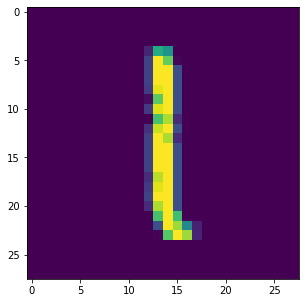

Predicted class label: 1


In [150]:
accuracy = baseline_model.validate(x_test, y_test)
print('Final model test accuracy:', accuracy)
print('Error Ratio:', 1 - accuracy)

img_index = np.random.choice(range(num_test_examples))
image = baseline_model.show_image(x_test, img_index)

(output_distribution,
 prediction, indicator_vec) = baseline_model.infer(image)
print('Predicted class label:', prediction)

## Comparison 1: Dropout w/ logistic activation

In [0]:
comparison1_model = MNISTClassifier(use_dropout=True,
                                    use_maxnorm_regularization=False,
                                    hidden_unit_activation='sigmoid',
                                    number_hidden_layers=3,
                                    hidden_unit_width=1024,
                                    optimizer_name='SGD',
                                    learning_rate=0.01,
                                    momentum=0.95)

Training

In [152]:
history_1 = comparison1_model.train(x_train, y_train, num_epochs=max_epochs)

Epoch 1/100
446/446 [==============================] - 2s 3ms/step - loss: 2.3733 - accuracy: 0.1143 - val_loss: 2.2714 - val_accuracy: 0.1963
Epoch 2/100
446/446 [==============================] - 1s 3ms/step - loss: 2.1338 - accuracy: 0.2143 - val_loss: 1.4161 - val_accuracy: 0.5187
Epoch 3/100
446/446 [==============================] - 1s 3ms/step - loss: 1.2506 - accuracy: 0.5277 - val_loss: 0.7346 - val_accuracy: 0.7393
Epoch 4/100
446/446 [==============================] - 1s 3ms/step - loss: 0.9363 - accuracy: 0.6682 - val_loss: 0.5728 - val_accuracy: 0.8237
Epoch 5/100
446/446 [==============================] - 1s 3ms/step - loss: 0.7811 - accuracy: 0.7351 - val_loss: 0.4342 - val_accuracy: 0.8833
Epoch 6/100
446/446 [==============================] - 1s 3ms/step - loss: 0.6750 - accuracy: 0.7776 - val_loss: 0.3664 - val_accuracy: 0.8960
Epoch 7/100
446/446 [==============================] - 1s 3ms/step - loss: 0.6082 - accuracy: 0.8034 - val_loss: 0.3284 - val_accuracy: 0.9110

Evaluating the Learned Model:

313/313 [==============================] - 1s 2ms/step - loss: 0.1077 - accuracy: 0.9652
Final model test accuracy: 0.9652000069618225
Error Ratio: 0.03479999303817749


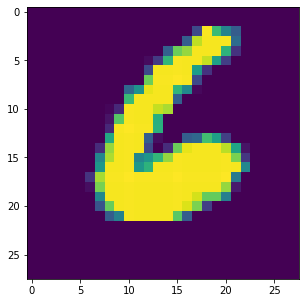

Predicted class label: 6


In [153]:
accuracy = comparison1_model.validate(x_test, y_test)
print('Final model test accuracy:', accuracy)
print('Error Ratio:', 1 - accuracy)

img_index = np.random.choice(range(num_test_examples))
image = comparison1_model.show_image(x_test, img_index)

(output_distribution,
 prediction, indicator_vec) = comparison1_model.infer(image)
print('Predicted class label:', prediction)


## Comparison 2: Dropout w/ RELU activation

In [0]:
comparison2_model = MNISTClassifier(use_dropout=True,
                                    use_maxnorm_regularization=False,
                                    hidden_unit_activation='relu',
                                    number_hidden_layers=3,
                                    hidden_unit_width=1024,
                                    optimizer_name='SGD',
                                    learning_rate=0.0008,
                                    momentum=0.95)

Training

In [155]:
history_2 = comparison2_model.train(x_train, y_train, num_epochs=max_epochs)

Epoch 1/100
446/446 [==============================] - 2s 3ms/step - loss: 1.5506 - accuracy: 0.4775 - val_loss: 0.4708 - val_accuracy: 0.8723
Epoch 2/100
446/446 [==============================] - 1s 3ms/step - loss: 0.7086 - accuracy: 0.7697 - val_loss: 0.2997 - val_accuracy: 0.9173
Epoch 3/100
446/446 [==============================] - 1s 3ms/step - loss: 0.5582 - accuracy: 0.8235 - val_loss: 0.2405 - val_accuracy: 0.9317
Epoch 4/100
446/446 [==============================] - 1s 3ms/step - loss: 0.4818 - accuracy: 0.8501 - val_loss: 0.2060 - val_accuracy: 0.9383
Epoch 5/100
446/446 [==============================] - 1s 3ms/step - loss: 0.4345 - accuracy: 0.8655 - val_loss: 0.1801 - val_accuracy: 0.9460
Epoch 6/100
446/446 [==============================] - 1s 3ms/step - loss: 0.3934 - accuracy: 0.8796 - val_loss: 0.1643 - val_accuracy: 0.9520
Epoch 7/100
446/446 [==============================] - 1s 3ms/step - loss: 0.3658 - accuracy: 0.8874 - val_loss: 0.1502 - val_accuracy: 0.9560

Evaluating the Learned Model:

313/313 [==============================] - 1s 2ms/step - loss: 0.0517 - accuracy: 0.9838
Final model test accuracy: 0.9837999939918518
Error Ratio: 0.016200006008148193


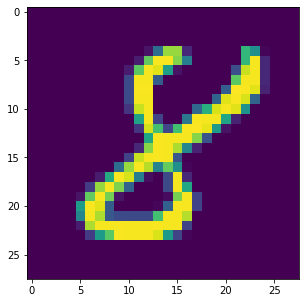

Predicted class label: 8


In [156]:
accuracy = comparison2_model.validate(x_test, y_test)
print('Final model test accuracy:', accuracy)
print('Error Ratio:', 1 - accuracy)

img_to_try = x_test[None, np.random.choice(range(num_test_examples)), :, :, :]
(output_distribution,
 prediction, indicator_vec) = comparison2_model.infer(img_to_try)
plt.imshow(img_to_try[0, :, :, 0])
plt.show()
print('Predicted class label:', prediction)

## Comparison 3: Dropout + max norm, w/ RELU activation

*norm is a hyperparameter, so we're going to just try a few values*

In [0]:
comparison3_model = MNISTClassifier(use_dropout=True,
                                    use_maxnorm_regularization=True,
                                    maxnorm_constraint=2.0,
                                    hidden_unit_activation='relu',
                                    number_hidden_layers=3,
                                    hidden_unit_width=1024,
                                    optimizer_name='SGD',
                                    learning_rate=0.0008,
                                    momentum=0.95)

Training

In [158]:
history_3 = comparison3_model.train(x_train, y_train, num_epochs=max_epochs)

Epoch 1/100
446/446 [==============================] - 2s 4ms/step - loss: 1.5550 - accuracy: 0.4789 - val_loss: 0.4577 - val_accuracy: 0.8780
Epoch 2/100
446/446 [==============================] - 2s 3ms/step - loss: 0.7079 - accuracy: 0.7724 - val_loss: 0.2862 - val_accuracy: 0.9200
Epoch 3/100
446/446 [==============================] - 1s 3ms/step - loss: 0.5504 - accuracy: 0.8268 - val_loss: 0.2271 - val_accuracy: 0.9377
Epoch 4/100
446/446 [==============================] - 1s 3ms/step - loss: 0.4799 - accuracy: 0.8485 - val_loss: 0.2000 - val_accuracy: 0.9420
Epoch 5/100
446/446 [==============================] - 1s 3ms/step - loss: 0.4312 - accuracy: 0.8672 - val_loss: 0.1742 - val_accuracy: 0.9473
Epoch 6/100
446/446 [==============================] - 1s 3ms/step - loss: 0.3885 - accuracy: 0.8798 - val_loss: 0.1587 - val_accuracy: 0.9543
Epoch 7/100
446/446 [==============================] - 1s 3ms/step - loss: 0.3606 - accuracy: 0.8889 - val_loss: 0.1433 - val_accuracy: 0.9617

Evaluating the Learned Model:

313/313 [==============================] - 1s 2ms/step - loss: 0.0528 - accuracy: 0.9836
Final model test accuracy: 0.9836000204086304
Error Ratio: 0.01639997959136963


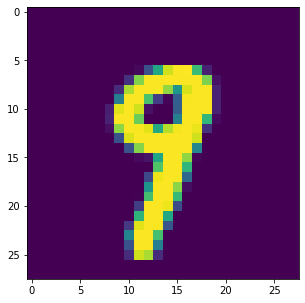

Predicted class label: 9


In [159]:
accuracy = comparison3_model.validate(x_test, y_test)
print('Final model test accuracy:', accuracy)
print('Error Ratio:', 1 - accuracy)

img_to_try = x_test[None, np.random.choice(range(num_test_examples)), :, :, :]
(output_distribution,
 prediction, indicator_vec) = comparison3_model.infer(img_to_try)
plt.imshow(img_to_try[0, :, :, 0])
plt.show()
print('Predicted class label:', prediction)

## Analysis: Model Comparisons

Here, we can see that the baseline, and the two ReLU examples matched the Hinton test accuracy pretty well, but the logistic + dropout example failed to live up to our expectations.

We also do not see the linear increase in error rate decrease as we go from baseline -> model 1 -> model 2 -> model 3, with model 2 never reaching stated accuracy, and models 2 and 3 being essentially indistinguishable.

This makes us think that for this dataset and with the SGD optimizer used in the paper, the regularization methods did not have nearly almost any effect. This is likely because the task and networks needed here were too simple to result in overfitting.


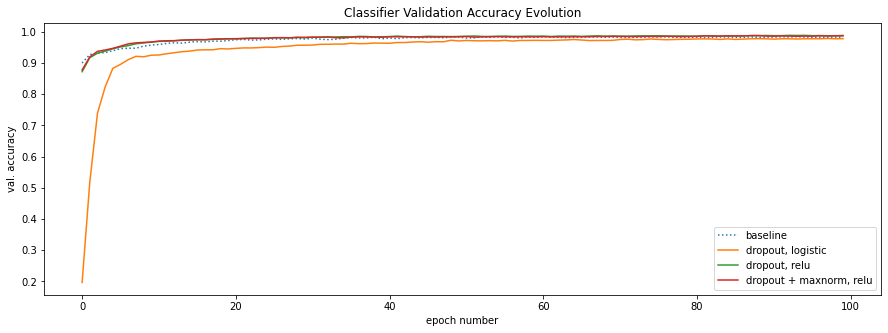

In [160]:
legendStrings = ('baseline',
                 'dropout, logistic',
                 'dropout, relu',
                 'dropout + maxnorm, relu')

histories = [history_1, history_2, history_3]
plot_history(histories, baseline_history=history_base, 
             legendStrings=legendStrings)